In [7]:

!wget https://github.com/todn0320/breast_Ultrasound_image/raw/main/Dataset_BUSI_with_GT.z01
!wget https://github.com/todn0320/breast_Ultrasound_image/raw/main/Dataset_BUSI_with_GT.zip

!zip -F /content/Dataset_BUSI_with_GT.zip --out /content/Dataset_BUSI_with_GT_total.zip
!unzip Dataset_BUSI_with_GT_total.zip

--2024-06-11 08:50:45--  https://github.com/todn0320/breast_Ultrasound_image/raw/main/Dataset_BUSI_with_GT.z01
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/todn0320/breast_Ultrasound_image/main/Dataset_BUSI_with_GT.z01 [following]
--2024-06-11 08:50:45--  https://raw.githubusercontent.com/todn0320/breast_Ultrasound_image/main/Dataset_BUSI_with_GT.z01
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104857600 (100M) [application/octet-stream]
Saving to: ‘Dataset_BUSI_with_GT.z01’

Dataset_BUSI_with_G 100%[===================>] 100.00M   354MB/s    in 0.3s    

2024-06-11 08:50:55 (354 MB/s) - ‘

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [9]:
image_size = (224,224)

# Define a transform to convert images to RGB
convert_to_rgb = transforms.Lambda(lambda image: image.convert('RGB'))
#greyscale
convert_to_grayscale = transforms.Lambda(lambda image: image.convert('L'))

train_transform=transforms.Compose([
    convert_to_rgb,
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform=transforms.Compose([
    convert_to_rgb,
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
EPOCHS = 100
#batch size can also be a learnable hyperparameter, but it was not included in the grid search
BATCH_SIZE = 16

In [11]:
# 데이터셋 로드 및 전처리
ds = ImageFolder('/content/Dataset_BUSI_with_GT', transform=train_transform, is_valid_file=is_not_mask)

print(ds.classes)
print(len(ds))
image, label = ds[0]
print(image.shape)

print("Number of samples: ", len(ds))
print("Detected Classes are: ", ds.class_to_idx)

train_size = int(0.7 * len(ds)) # 70% for training
val_size = int(0.15 * len(ds)) # 15% for validation
test_size = len(ds) - train_size - val_size # 15% for testing

train_ds, val_ds, test_ds = random_split(ds, [train_size, val_size, test_size])
print(f"train: {len(train_ds)} test: {len(test_ds)} val: {len(val_ds)}")
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


['benign', 'malignant', 'normal']
798
torch.Size([3, 224, 224])
Number of samples:  798
Detected Classes are:  {'benign': 0, 'malignant': 1, 'normal': 2}
train: 558 test: 121 val: 119


In [15]:
# 모델 초기화 (ResNet-50 사용)
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(train_loader.dataset)

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total
    return val_loss, val_acc

num_epochs = 50
best_val_loss = float('inf')

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

test_predicted_classes = []
test_true_classes = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_loss += criterion(outputs, labels).item()

        test_predicted_classes.extend(predicted.cpu().numpy())
        test_true_classes.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total
test_loss /= len(test_loader)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Epoch [1/50], Train Loss: 0.9332, Val Loss: 76.2661, Val Acc: 0.6218
Epoch [2/50], Train Loss: 0.7763, Val Loss: 6.7149, Val Acc: 0.6218
Epoch [3/50], Train Loss: 0.6527, Val Loss: 0.8464, Val Acc: 0.6891
Epoch [4/50], Train Loss: 0.6604, Val Loss: 1.4549, Val Acc: 0.5630
Epoch [5/50], Train Loss: 0.5851, Val Loss: 0.6393, Val Acc: 0.7143
Epoch [6/50], Train Loss: 0.5223, Val Loss: 0.7861, Val Acc: 0.6723
Epoch [7/50], Train Loss: 0.4530, Val Loss: 0.4854, Val Acc: 0.7899
Epoch [8/50], Train Loss: 0.4263, Val Loss: 0.8234, Val Acc: 0.7143
Epoch [9/50], Train Loss: 0.4829, Val Loss: 2.6100, Val Acc: 0.6639
Epoch [10/50], Train Loss: 0.4980, Val Loss: 0.6028, Val Acc: 0.7479
Epoch [11/50], Train Loss: 0.3717, Val Loss: 0.4864, Val Acc: 0.7563
Epoch [12/50], Train Loss: 0.3495, Val Loss: 0.8839, Val Acc: 0.7059
Epoch [13/50], Train Loss: 0.4158, Val Loss: 0.4411, Val Acc: 0.8319
Epoch [14/50], Train Loss: 0.3345, Val Loss: 0.6373, Val Acc: 0.7395
Epoch [15/50], Train Loss: 0.3082, Val Los

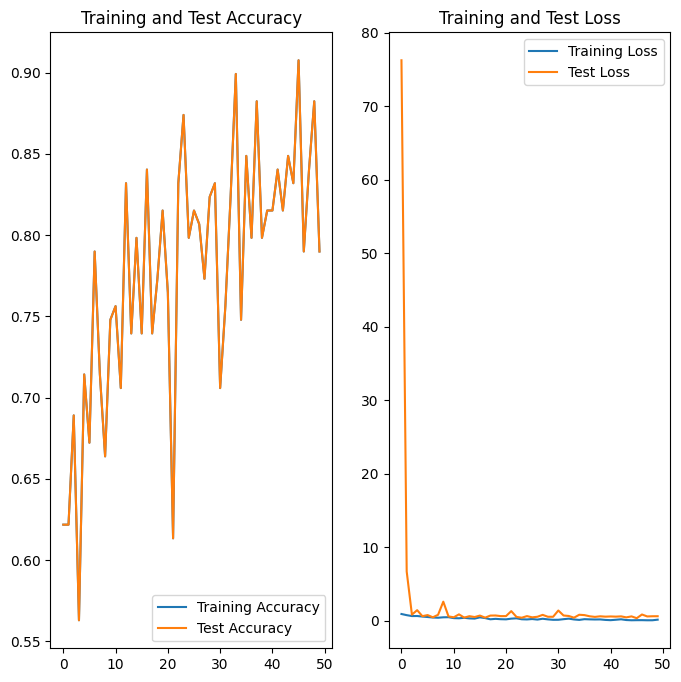

In [16]:
# 훈련 및 검증 손실 및 정확도 시각화
acc = val_accuracies
test_acc = val_accuracies

loss = train_losses
test_loss = val_losses

epochs_range = range(num_epochs)
test_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(test_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, torch.tensor(loss).cpu(), label='Training Loss')
plt.plot(test_range, torch.tensor(test_loss).cpu(), label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()

step: 0
predict: tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 2, 1, 0, 1, 2, 0, 0], device='cuda:0') accuracy: 100.0 loss: [0.9331522633097933, 0.7763229420535454, 0.6526549531140208, 0.6603935461317767, 0.5850782369840957, 0.5223062286240225, 0.45304723623405646, 0.4262635009797243, 0.48289673868900557, 0.49797561924944644, 0.37165531996757756, 0.3495294826646005, 0.4157555071256494, 0.3344852526982625, 0.30815700780747185, 0.4794956590966939, 0.3790512856189495, 0.21423742773285048, 0.2734256689052855, 0.22437031820790315, 0.20592438864878856, 0.30181451846835433, 0.3456730218771111, 0.21690981601461715, 0.192458727640704, 0.24992413039062186, 0.1725253688445228, 0.285861493225166, 0.203042680591238, 0.14278987808466811, 0.14734540121316056, 0.22879991237087488, 0.3015757952032337, 0.19160896950938797, 0.12982381374231375, 0.22985200736150946, 0.20417280057211504, 0.18686338092157062, 0.19562509045752574, 0.12891168186380977, 0.0936429655933786, 0.15111361394592937, 0.21287279851120433, 0.1125

step: 1
predict: tensor([0, 1, 2, 0, 1, 1, 0, 2, 1, 2, 2, 0, 1, 1, 0, 0], device='cuda:0') accuracy: 93.75 loss: [0.9331522633097933, 0.7763229420535454, 0.6526549531140208, 0.6603935461317767, 0.5850782369840957, 0.5223062286240225, 0.45304723623405646, 0.4262635009797243, 0.48289673868900557, 0.49797561924944644, 0.37165531996757756, 0.3495294826646005, 0.4157555071256494, 0.3344852526982625, 0.30815700780747185, 0.4794956590966939, 0.3790512856189495, 0.21423742773285048, 0.2734256689052855, 0.22437031820790315, 0.20592438864878856, 0.30181451846835433, 0.3456730218771111, 0.21690981601461715, 0.192458727640704, 0.24992413039062186, 0.1725253688445228, 0.285861493225166, 0.203042680591238, 0.14278987808466811, 0.14734540121316056, 0.22879991237087488, 0.3015757952032337, 0.19160896950938797, 0.12982381374231375, 0.22985200736150946, 0.20417280057211504, 0.18686338092157062, 0.19562509045752574, 0.12891168186380977, 0.0936429655933786, 0.15111361394592937, 0.21287279851120433, 0.1125

step: 2
predict: tensor([0, 2, 2, 0, 2, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0], device='cuda:0') accuracy: 93.75 loss: [0.9331522633097933, 0.7763229420535454, 0.6526549531140208, 0.6603935461317767, 0.5850782369840957, 0.5223062286240225, 0.45304723623405646, 0.4262635009797243, 0.48289673868900557, 0.49797561924944644, 0.37165531996757756, 0.3495294826646005, 0.4157555071256494, 0.3344852526982625, 0.30815700780747185, 0.4794956590966939, 0.3790512856189495, 0.21423742773285048, 0.2734256689052855, 0.22437031820790315, 0.20592438864878856, 0.30181451846835433, 0.3456730218771111, 0.21690981601461715, 0.192458727640704, 0.24992413039062186, 0.1725253688445228, 0.285861493225166, 0.203042680591238, 0.14278987808466811, 0.14734540121316056, 0.22879991237087488, 0.3015757952032337, 0.19160896950938797, 0.12982381374231375, 0.22985200736150946, 0.20417280057211504, 0.18686338092157062, 0.19562509045752574, 0.12891168186380977, 0.0936429655933786, 0.15111361394592937, 0.21287279851120433, 0.1125

step: 3
predict: tensor([1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0') accuracy: 93.75 loss: [0.9331522633097933, 0.7763229420535454, 0.6526549531140208, 0.6603935461317767, 0.5850782369840957, 0.5223062286240225, 0.45304723623405646, 0.4262635009797243, 0.48289673868900557, 0.49797561924944644, 0.37165531996757756, 0.3495294826646005, 0.4157555071256494, 0.3344852526982625, 0.30815700780747185, 0.4794956590966939, 0.3790512856189495, 0.21423742773285048, 0.2734256689052855, 0.22437031820790315, 0.20592438864878856, 0.30181451846835433, 0.3456730218771111, 0.21690981601461715, 0.192458727640704, 0.24992413039062186, 0.1725253688445228, 0.285861493225166, 0.203042680591238, 0.14278987808466811, 0.14734540121316056, 0.22879991237087488, 0.3015757952032337, 0.19160896950938797, 0.12982381374231375, 0.22985200736150946, 0.20417280057211504, 0.18686338092157062, 0.19562509045752574, 0.12891168186380977, 0.0936429655933786, 0.15111361394592937, 0.21287279851120433, 0.1125

step: 4
predict: tensor([0, 2, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0') accuracy: 81.25 loss: [0.9331522633097933, 0.7763229420535454, 0.6526549531140208, 0.6603935461317767, 0.5850782369840957, 0.5223062286240225, 0.45304723623405646, 0.4262635009797243, 0.48289673868900557, 0.49797561924944644, 0.37165531996757756, 0.3495294826646005, 0.4157555071256494, 0.3344852526982625, 0.30815700780747185, 0.4794956590966939, 0.3790512856189495, 0.21423742773285048, 0.2734256689052855, 0.22437031820790315, 0.20592438864878856, 0.30181451846835433, 0.3456730218771111, 0.21690981601461715, 0.192458727640704, 0.24992413039062186, 0.1725253688445228, 0.285861493225166, 0.203042680591238, 0.14278987808466811, 0.14734540121316056, 0.22879991237087488, 0.3015757952032337, 0.19160896950938797, 0.12982381374231375, 0.22985200736150946, 0.20417280057211504, 0.18686338092157062, 0.19562509045752574, 0.12891168186380977, 0.0936429655933786, 0.15111361394592937, 0.21287279851120433, 0.1125

step: 6
predict: tensor([0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 0, 2, 0, 0, 0], device='cuda:0') accuracy: 87.5 loss: [0.9331522633097933, 0.7763229420535454, 0.6526549531140208, 0.6603935461317767, 0.5850782369840957, 0.5223062286240225, 0.45304723623405646, 0.4262635009797243, 0.48289673868900557, 0.49797561924944644, 0.37165531996757756, 0.3495294826646005, 0.4157555071256494, 0.3344852526982625, 0.30815700780747185, 0.4794956590966939, 0.3790512856189495, 0.21423742773285048, 0.2734256689052855, 0.22437031820790315, 0.20592438864878856, 0.30181451846835433, 0.3456730218771111, 0.21690981601461715, 0.192458727640704, 0.24992413039062186, 0.1725253688445228, 0.285861493225166, 0.203042680591238, 0.14278987808466811, 0.14734540121316056, 0.22879991237087488, 0.3015757952032337, 0.19160896950938797, 0.12982381374231375, 0.22985200736150946, 0.20417280057211504, 0.18686338092157062, 0.19562509045752574, 0.12891168186380977, 0.0936429655933786, 0.15111361394592937, 0.21287279851120433, 0.11255

IndexError: index 7 is out of bounds for dimension 0 with size 7

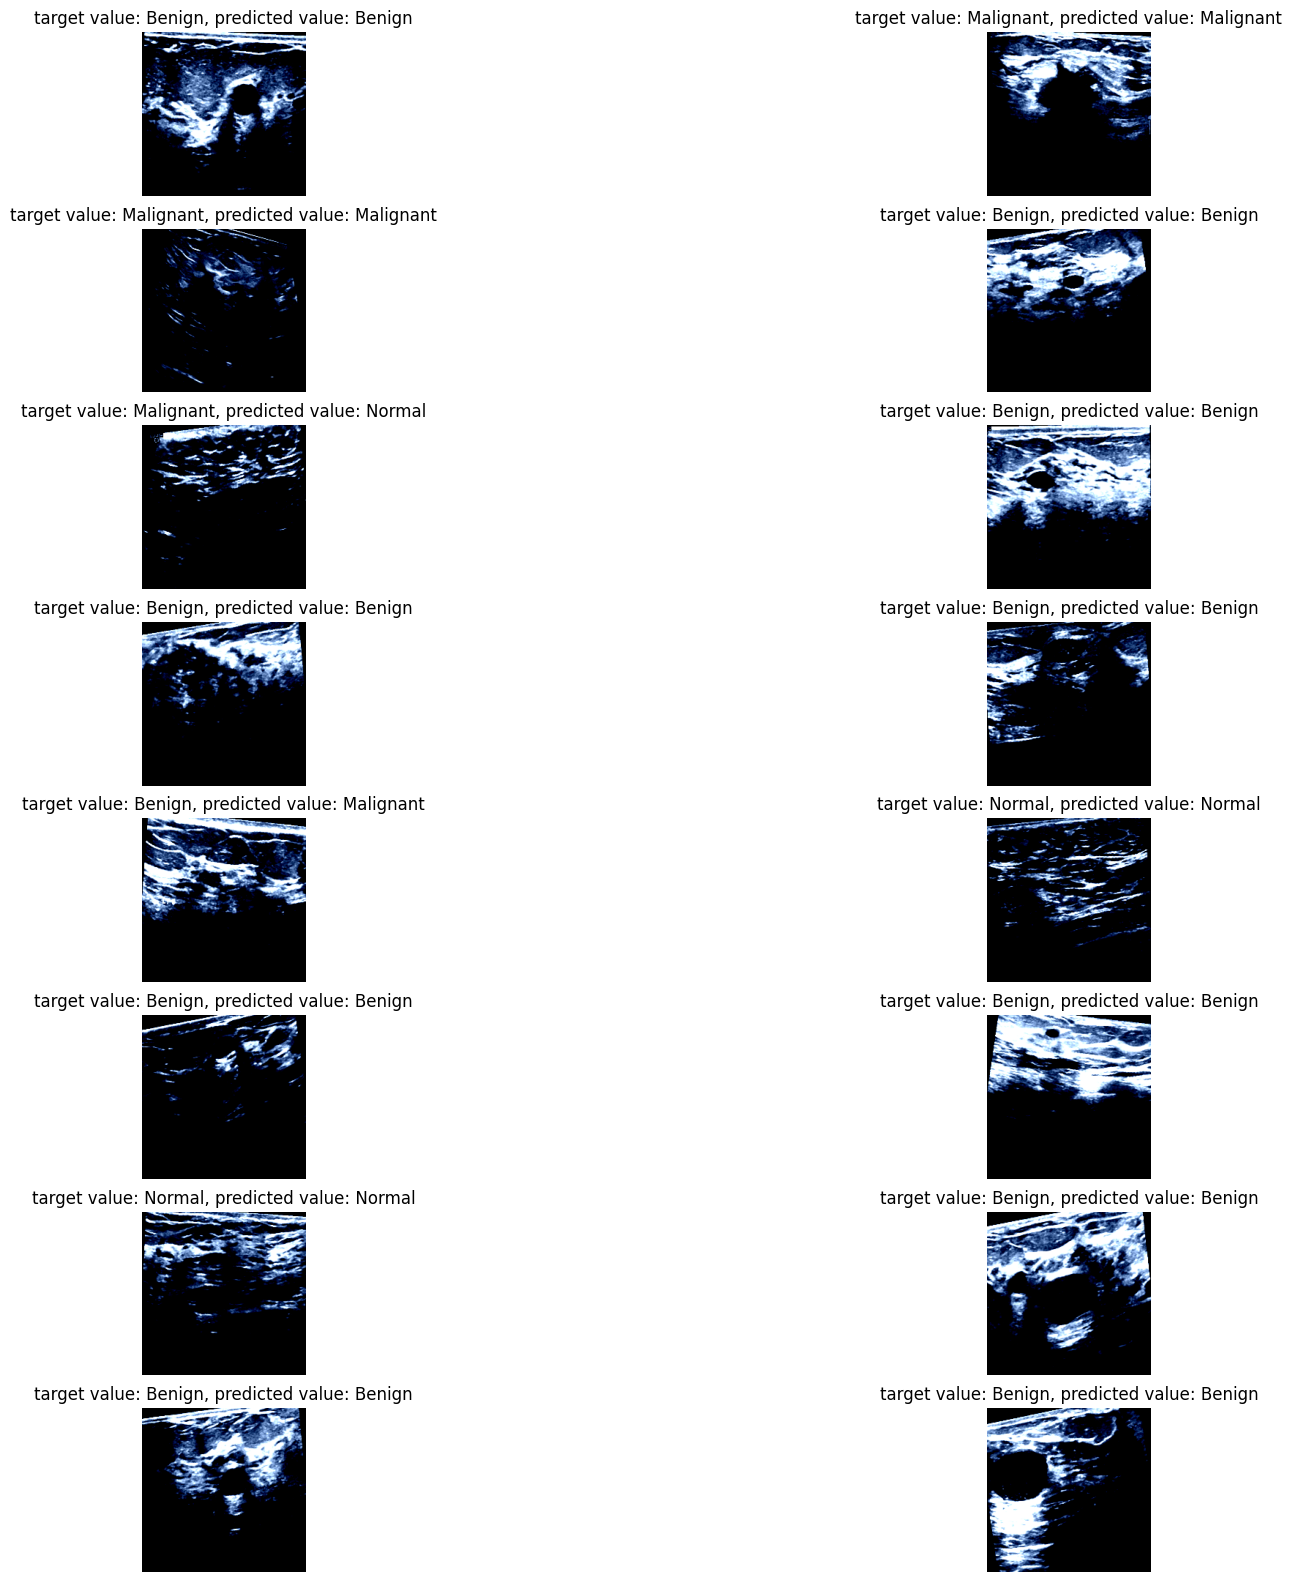

In [17]:
EVAL_BATCH = 16
eval_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

plt.figure(figsize=(20, 20))

# Disable grad
with torch.no_grad():
    for step, (x, y) in enumerate(eval_loader):
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        _, eval_predictions = torch.max(outputs, 1)
        acc_value = (eval_predictions == y)
        accuracy = acc_value.sum().item() / len(acc_value) * 100
        print(f"step: {step}")
        print(f"predict: {eval_predictions} accuracy: {accuracy} loss: {loss}")
        print(f"targets: {y}")

        for i in range(EVAL_BATCH):
            value_predicted = "Benign" if eval_predictions[i].item() == 0 else "Malignant" if eval_predictions[i].item() == 1 else "Normal"
            value_target = "Benign" if y[i].item() == 0 else "Malignant" if y[i].item() == 1 else "Normal"

            image = x[i].cpu()
            ax = plt.subplot(int(EVAL_BATCH/2), int(EVAL_BATCH/8), i + 1)
            plt.imshow(image.permute(1, 2, 0))
            plt.title(f"target value: {value_target}, predicted value: {value_predicted}")
            ax.set_axis_off()

[[59  8  4]
 [ 6 21  1]
 [ 1  5 16]]


Text(0.5, 47.7222222222222, 'Predicted Labels')

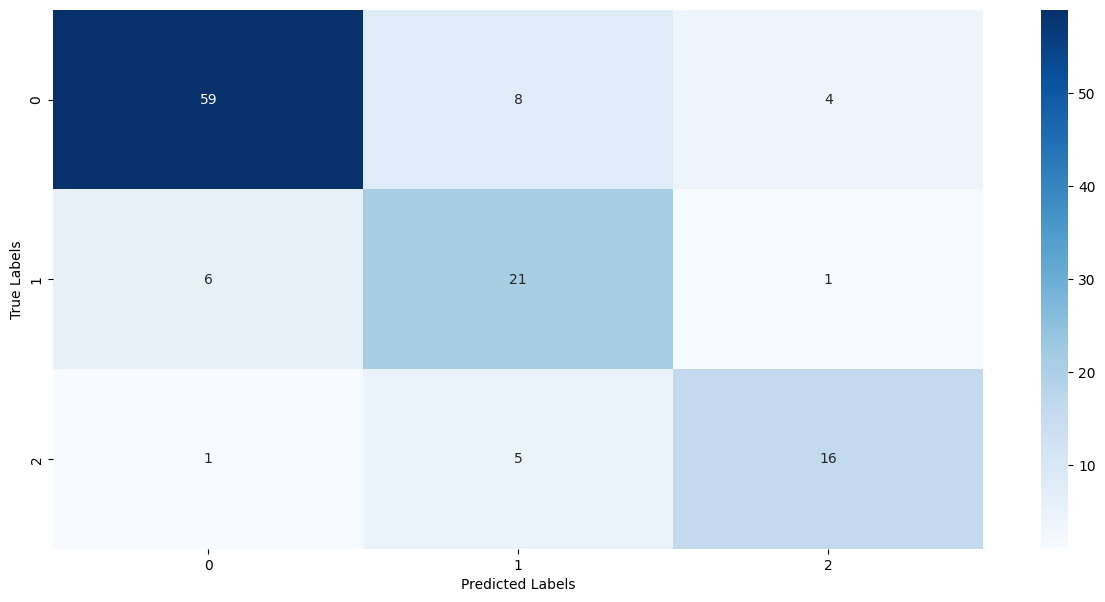

In [18]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(test_true_classes, test_predicted_classes)
print(conf_mat)
plt.figure(figsize=(15,7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')